# DecisionTreeClassifier

Un árbol de decisión es un modelo muy simple, intuitivo e interpretable. Resulta muy útil analizar sus resultados para detectar predictores fuertes y features irrelevantes, para poder afinar los preprocessings de modelos más complejos y mejorar su eficiencia. Se entrenaron árboles de decisión con dos preprocessings distintos: uno más sencillo y otro más sofisticado.

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import numpy as np
from scoring import *
pd.set_option('display.max_rows', 10)

## Preprocessing Nº1

In [2]:
df_features, df_target = get_datasets(fecha_to_int=True)

df_features = dummy(df_features, [
    "direccion_viento_tarde",
    "direccion_viento_temprano",
    "rafaga_viento_max_direccion",
    "barrio"
])

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = simple_imputer()
pipe.fit(X_train, Y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Grid search de hiperparámetros

In [3]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8509136763607907

In [4]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.852851,0.839387,0.70466,0.48647,0.575581


In [5]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,gini,11,150,0.850914,0.837009,0.705018,0.469346,0.563054
1,gini,12,150,0.850904,0.837009,0.705018,0.469346,0.563054
2,gini,13,175,0.850888,0.836603,0.700469,0.474515,0.564984
3,gini,10,150,0.850852,0.837009,0.705018,0.469346,0.563054
4,gini,11,175,0.850822,0.836603,0.700469,0.474515,0.564984
...,...,...,...,...,...,...,...,...
667,gini,3,500,0.787686,0.827854,0.736649,0.362186,0.484594
668,gini,3,400,0.787681,0.827854,0.736649,0.362186,0.484594
669,gini,3,325,0.787671,0.827854,0.736649,0.362186,0.484594
670,gini,3,350,0.787655,0.827854,0.736649,0.362186,0.484594


Vemos que los mejores modelos utilizaron ***gini*** como criterio de separación. Esto es interesante, ya que generalmente el criterio ***entropy*** suele dar mejores resultados

### Importancia de cada feature

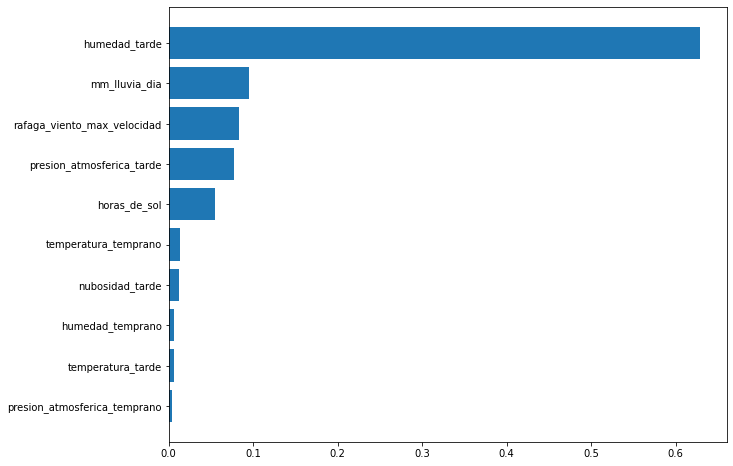

In [6]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=10, head=True)

Las features que el modelo consideró más importantes coinciden con las analizadas en el TP1

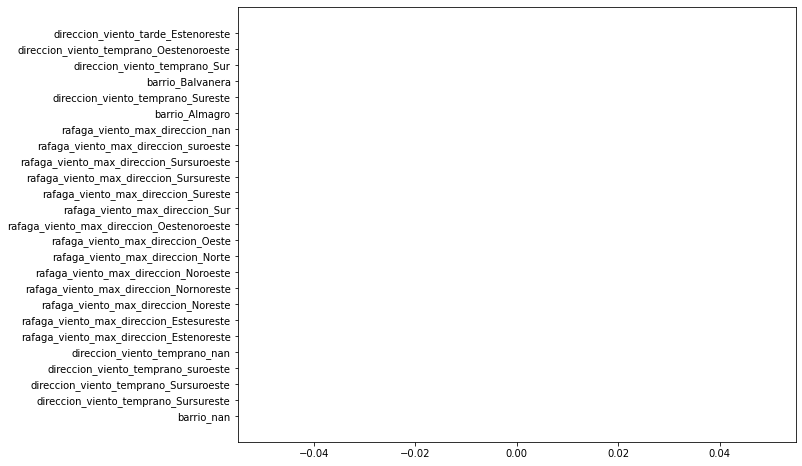

In [7]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=25, head=False)

Vemos que los barrios y las direcciones de viento no fueron útiles para el modelo utilizando One Hot Encoding. Para el segundo preprocessing, se utilizaron encodings diferentes para comparar resultados.

## Preprocessing Nº2

In [8]:
df_features, df_target = get_datasets(fecha_to_int=False)

viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = dia_a_mes(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = iterative_imputer(max_iter=100)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Grid search de hiperparámetros

In [9]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8551373654785872

In [10]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.858443,0.843212,0.720418,0.489712,0.583073


In [11]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,entropy,9,200,0.855137,0.838993,0.709256,0.476532,0.569845
1,entropy,10,200,0.854776,0.838993,0.709256,0.476532,0.569845
2,entropy,9,225,0.854718,0.838918,0.707276,0.479354,0.571051
3,entropy,14,225,0.854705,0.838918,0.707276,0.479354,0.571051
4,entropy,13,225,0.854689,0.838918,0.707276,0.479354,0.571051
...,...,...,...,...,...,...,...,...
667,gini,3,200,0.810853,0.828470,0.731475,0.370174,0.491249
668,gini,3,175,0.810853,0.828470,0.731475,0.370174,0.491249
669,gini,3,150,0.810853,0.828470,0.731475,0.370174,0.491249
670,gini,3,125,0.810853,0.828470,0.731475,0.370174,0.491249


Los resultados son ligeramente mejores que en el primer preprocessing. En cuanto a los hiperparámetros encontrados, vemos que los árboles resultantes son menos profundos y, por lo tanto, más simples. Esto es algo bueno, ya que quiere decir que tiene más posibilidades de generalizar mejor y tener mejores resultados en instancias no vistas anteriormente. También vemos que los mejores árboles utilizaron ***entropy*** en lugar de ***gini***

### Importancia de cada feature

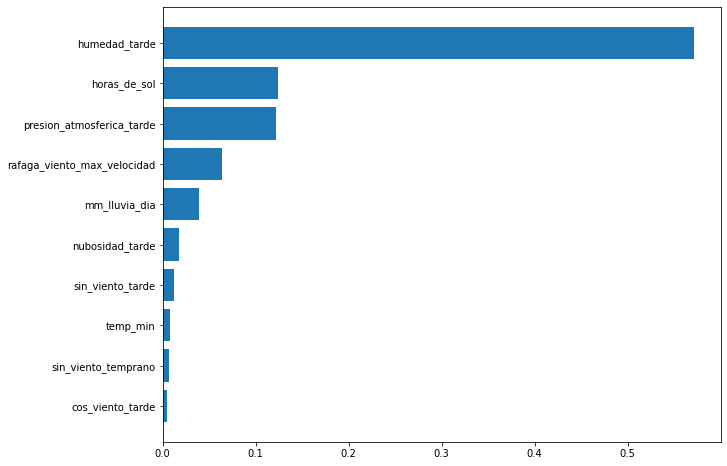

In [12]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=10, head=True)

Podemos observar que el preprocessing ***viento_trigonometrico*** fue de utilidad, ya que algunas features relacionadas a la dirección del viento ganaron importancia en el árbol.

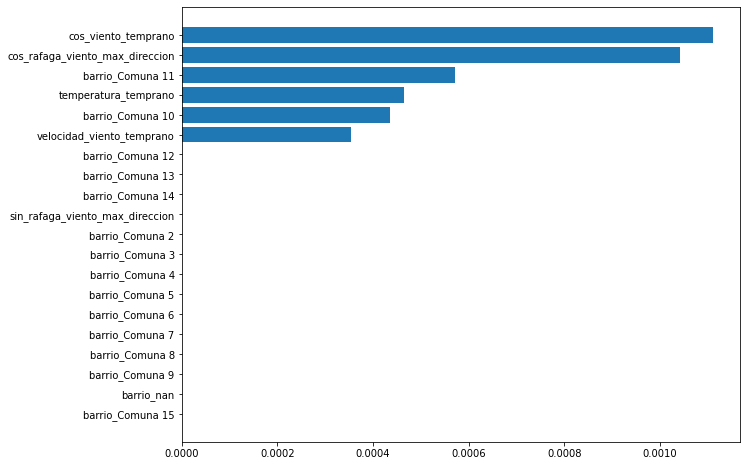

In [13]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=20, head=False)

El hashing de los barrios no resultó tan útil. Como genera un aumento considerable de la dimensionalidad del dataset, en futuros modelos debería considerarse la posibilidad de descartar la feature completa.

### Matriz de confusión

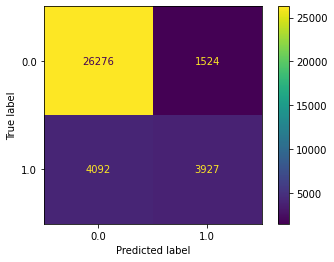

In [14]:
ConfusionMatrixDisplay.from_predictions(Y_test, grid.best_estimator_.predict(X_test))

Podemos ver que la cantidad de falsos negativos es más del doble de la cantidad de falsos positivos. Esto se debe a que el dataset se encontraba desbalanceado, por lo que el modelo tiende a devolver 0 con más frecuencia, ya que en las hojas tendrá mayor cantidad de instancias negativas que positivas.

## Cambiando los pesos de las clases

Podemos intentar solucionar el problema anterior modificando el parámetro `class_weight` para que modifique la importancia de cada clase de la variable target en funcion de su frecuencia en el dataset

In [15]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8542981296878718

In [16]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.857091,0.786594,0.516088,0.750094,0.611467


In [17]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,gini,8,150,0.854298,0.775643,0.499480,0.765192,0.604333
1,gini,8,100,0.854197,0.777883,0.502735,0.756866,0.604121
2,gini,9,200,0.854183,0.769780,0.491416,0.772710,0.600523
3,entropy,9,175,0.854154,0.776109,0.500142,0.763379,0.604276
4,gini,9,150,0.854028,0.770276,0.491850,0.773585,0.601273
...,...,...,...,...,...,...,...,...
667,gini,3,700,0.817297,0.758295,0.474877,0.745516,0.580059
668,gini,3,725,0.817297,0.758295,0.474877,0.745516,0.580059
669,gini,3,775,0.817297,0.758295,0.474877,0.745516,0.580059
670,gini,3,450,0.817297,0.758295,0.474877,0.745516,0.580059


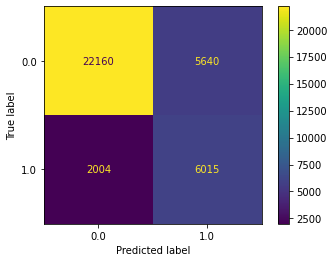

In [18]:
ConfusionMatrixDisplay.from_predictions(Y_test, grid.best_estimator_.predict(X_test))

Los mejores modelos resultaron ser más simples (menor profundidad) y mantuvieron el AUC ROC entre los mismos valores (aunque las otras métricas cambiaron). Vemos también que el recall aumentó bastante y la precisión disminuyó, ya que disminuyó la cantidad de falsos negativos y aumentó la cantidad de falsos positivos.

El modelo resultante no fue superador, ya que ROC-AUC, la métrica que buscamos optimizar, no aumentó.

### Importancia de cada feature

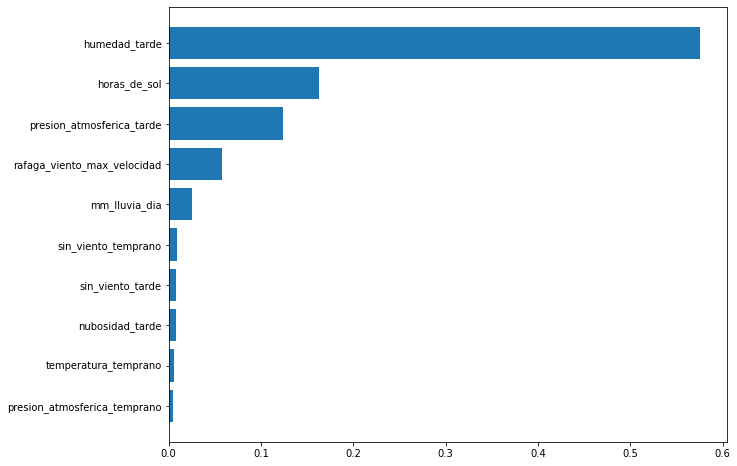

In [19]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=10, head=True)

La importancia de las features se mantuvo similar, aunque algunas aumentaron un poco, como el caso de **sin_viento_temprano**.

## Calibrando el modelo

Al calibrar un modelo, los resultados de **predict_proba()** son más precisos, lo cual podría significar una mejora en los resultados del AUC ROC score.

In [20]:
tree = DecisionTreeClassifier(criterion="entropy", random_state=0)
calib = CalibratedClassifierCV(base_estimator=tree, n_jobs=-1)

In [21]:
parameters = {
    "base_estimator__max_depth": np.arange(5,15,1),
}

grid = GridSearchCV(calib,
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8673567096863886

In [22]:
grid_history_table(grid)

,param_base_estimator__max_depth,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,9,0.867357,0.844195,0.760084,0.444370,0.560840
1,8,0.866330,0.844571,0.750138,0.458471,0.569108
2,10,0.866113,0.842662,0.774612,0.419324,0.544079
3,11,0.863822,0.839805,0.784889,0.391929,0.522769
4,7,0.863479,0.843744,0.739955,0.465856,0.571703
5,12,0.861019,0.836693,0.796271,0.363661,0.499262
6,6,0.858873,0.842541,0.738263,0.460080,0.566660
7,13,0.856208,0.833251,0.808550,0.334453,0.473119
8,5,0.852536,0.840467,0.736295,0.448062,0.557021
9,14,0.851086,0.831612,0.826086,0.314107,0.455086


In [23]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.870364,0.848656,0.763062,0.469884,0.581616


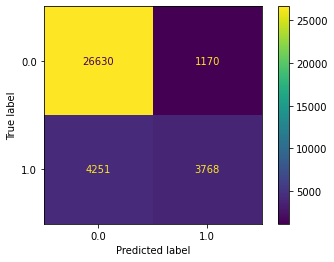

In [24]:
ConfusionMatrixDisplay.from_predictions(Y_test, grid.best_estimator_.predict(X_test))

El score aumentó bastante, lo cual coincide con lo esperado

## Modelo final

El árbol calibrado y entrenado con el preprocessing Nº2 resultó ser el mejor modelo, ya que tuvo el mejor score y su complejidad (en cuanto a profundidad) es similar a la del resto

## Predicción de nuevos datos

In [25]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra, fecha_to_int=False)
viento_trigonometrico(df_extra)
df_extra = barrios_a_comunas(df_extra)
df_extra = dia_a_mes(df_extra)

model = grid.best_estimator_

# El pipe ya tiene el IterativeImputer()
pipe.steps.append(("tree", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/DecisionTreeClassifier.csv")

## Predicción en Holdout

In [26]:
df_features_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
df_target_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(df_features_holdout, df_target_holdout, fecha_to_int=False)
viento_trigonometrico(df_features_holdout)
df_features_holdout = barrios_a_comunas(df_features_holdout)
df_features_holdout = dia_a_mes(df_features_holdout)

In [27]:
metrics_table(df_target_holdout, pipe.predict(df_features_holdout), pipe.predict_proba(df_features_holdout)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.869597,0.842175,0.748318,0.438659,0.553096


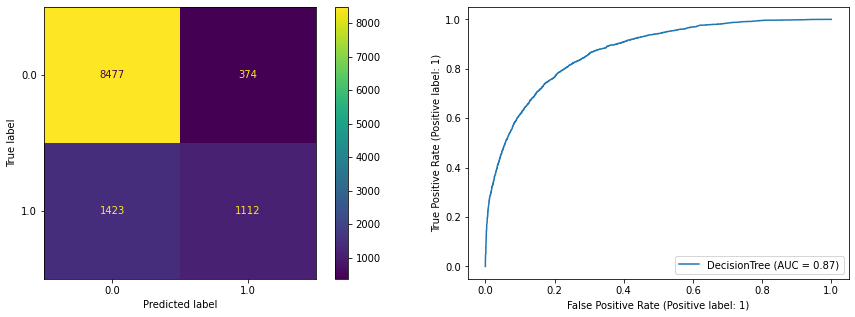

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

ConfusionMatrixDisplay.from_predictions(df_target_holdout, pipe.predict(df_features_holdout), ax=axs[0])
RocCurveDisplay.from_predictions(df_target_holdout, pipe.predict_proba(df_features_holdout)[:,1], ax=axs[1], name="DecisionTree")
plt.show()

Podemos observar que, frente a datos nuevos como lo son los de holdout, el modelo se comporta bastante bien. Los scores de AUC-ROC y Accuracy bajaron muy poco, aunque Precision, Recall y F1 score lo hicieron un poco más. Las proporciones de valores en la matriz de confusión se mantuvieron similares.

Podemos concluir que el modelo final no overfitea, y constituye una baseline sólida para análisis posteriores.